# Ripple Detection


## Overview


_Developer Note:_ if you may make a PR in the future, be sure to copy this
notebook, and use the `gitignore` prefix `temp` to avoid future conflicts.

This is one notebook in a multi-part series on Spyglass.

- To set up your Spyglass environment and database, see
  [the Setup notebook](./00_Setup.ipynb)
- For additional info on DataJoint syntax, including table definitions and
  inserts, see
  [the Insert Data notebook](./01_Insert_Data.ipynb)

Ripple detection depends on a set of LFPs, the parameters used for detection and the speed of the animal. You will need `RippleLFPSelection`, `RippleParameters`, and `PositionOutput` to be populated accordingly.


## Imports


In [32]:
import os
import datajoint as dj
import numpy as np
import pandas as pd

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
dj.config.load("dj_local_conf.json")  # load config for database connection info

import spyglass.common as sgc
import spyglass.position.v1 as sgp
import spyglass.lfp.analysis.v1 as lfp_analysis
from spyglass.lfp import LFPOutput
import spyglass.lfp as sglfp
from spyglass.position import PositionOutput
import spyglass.ripple.v1 as sgrip
import spyglass.ripple.v1 as sgr

# ignore datajoint+jupyter async warnings
import warnings

warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=ResourceWarning)

## Generate LFP Ripple Band

First, we need to generate a filter band from the LFP data at the ripple frequency.  This process is analogous to that in [30_LFP.ipynb](31_Theta.ipynb). 

#### Make LFP

If you have already populated the LFP table for your data you may skip this step. Here, we will begin by creating a lfp group of just electrodes in the hippocampus region, and populate the lfp on a subsetted interval:

In [9]:
nwb_file_name = "mediumnwb20230802_.nwb"
lfp_electrode_group_name = "test_hippocampus"
interval_list_name = "02_r1_ripple_demo"

# select hippocampus electrodes
electrodes_df = (
    pd.DataFrame(
        (
            sgc.Electrode
            & {"nwb_file_name": nwb_file_name, "bad_channel": "False"}
        )
        * (sgc.BrainRegion & {"region_name": "hippocampus"})
    )
    .loc[
        :,
        [
            "nwb_file_name",
            "electrode_id",
            "region_name",
            "electrode_group_name",
        ],
    ]
    .sort_values(by="electrode_id")
)
# for the purpose of the demo, we will only use one electrode per electrode group
electrodes_df = pd.DataFrame(
    [
        electrodes_df[electrodes_df.electrode_group_name == str(i)].iloc[0]
        for i in np.unique(electrodes_df.electrode_group_name.values)
    ]
)

# create lfp_electrode_group
lfp_eg_key = {
    "nwb_file_name": nwb_file_name,
    "lfp_electrode_group_name": lfp_electrode_group_name,
}
sglfp.lfp_electrode.LFPElectrodeGroup.create_lfp_electrode_group(
    nwb_file_name=nwb_file_name,
    group_name=lfp_electrode_group_name,
    electrode_list=electrodes_df.electrode_id.tolist(),
)

# make a shorter interval to run this demo on
interval_start = (
    sgc.IntervalList
    & {"nwb_file_name": nwb_file_name, "interval_list_name": "02_r1"}
).fetch1("valid_times")[0][0]
truncated_interval = np.array(
    [[interval_start, interval_start + 120]]
)  # first 2 minutes of epoch
sgc.IntervalList.insert1(
    {
        "nwb_file_name": nwb_file_name,
        "interval_list_name": "02_r1_ripple_demo",
        "valid_times": truncated_interval,
    },
    skip_duplicates=True,
)

# make the lfp selection
lfp_s_key = lfp_eg_key.copy()
lfp_s_key.update(
    {
        "target_interval_list_name": interval_list_name,
        "filter_name": "LFP 0-400 Hz",
        "filter_sampling_rate": 30_000,  # sampling rate of the data (Hz)
        "target_sampling_rate": 1_000,  # smpling rate of the lfp output (Hz)
    }
)
sglfp.v1.LFPSelection.insert1(lfp_s_key, skip_duplicates=True)

# populate the lfp
sglfp.v1.LFPV1.populate(lfp_s_key, display_progress=True)
sglfp.v1.LFPV1 & lfp_s_key

nwb_file_name name of the NWB file,lfp_electrode_group_name the name of this group of electrodes,target_interval_list_name descriptive name of this interval list,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_object_id the NWB object ID for loading this object from the file,"lfp_sampling_rate the sampling rate, in HZ"
mediumnwb20230802_.nwb,test_hippocampus,02_r1_ripple_demo,LFP 0-400 Hz,30000,mediumnwb20230802_7625J294O4.nwb,lfp_test_hippocampus_02_r1_ripple_demo_valid times,95ac8100-eca8-4dff-a504-b1c139a2a3af,1000.0


#### Populate Ripple Band
We now create a filter for this frequency band

In [10]:
sgc.FirFilterParameters().add_filter(
    filter_name="Ripple 150-250 Hz",
    fs=1000.0,
    filter_type="bandpass",
    band_edges=[140, 150, 250, 260],
    comments="ripple band filter for 1 kHz data",
)

sgc.FirFilterParameters() & "filter_name='Ripple 150-250 Hz'"

filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,filter_type,filter_low_stop lowest frequency for stop band for low frequency side of filter,filter_low_pass lowest frequency for pass band of low frequency side of filter,filter_high_pass highest frequency for pass band for high frequency side of filter,filter_high_stop highest frequency for stop band of high frequency side of filter,filter_comments comments about the filter,filter_band_edges numpy array containing the filter bands (redundant with individual parameters),filter_coeff numpy array containing the filter coefficients
Ripple 150-250 Hz,1000,lowpass,140.0,150.0,250.0,260.0,ripple band filter for 1 kHz data,=BLOB=,=BLOB=


We can then populate the ripple band

In [18]:
from spyglass.lfp.analysis.v1 import lfp_band

filter_name = "Ripple 150-250 Hz"
lfp_band_electrode_ids = (
    electrodes_df.electrode_id.tolist()
)  # assumes we've filtered these electrodes
lfp_band_sampling_rate = 1000  # desired sampling rate

lfp_merge_id = (LFPOutput.LFPV1() & lfp_s_key).fetch1("merge_id")
lfp_band.LFPBandSelection().set_lfp_band_electrodes(
    nwb_file_name=nwb_file_name,
    lfp_merge_id=lfp_merge_id,
    electrode_list=lfp_band_electrode_ids,
    filter_name=filter_name,
    interval_list_name=interval_list_name,
    reference_electrode_list=[-1],  # -1 means no ref electrode for all channels
    lfp_band_sampling_rate=lfp_band_sampling_rate,
)

lfp_band.LFPBandV1.populate(
    {"lfp_merge_id": lfp_merge_id, "filter_name": filter_name},
    display_progress=True,
)
lfp_band.LFPBandV1 & {"lfp_merge_id": lfp_merge_id, "filter_name": filter_name}

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,analysis_file_name name of the file,interval_list_name descriptive name of this interval list,lfp_band_object_id the NWB object ID for loading this object from the file
e5c8a41b-5bb1-c12c-d306-e80e5491d6dd,Ripple 150-250 Hz,1000,mediumnwb20230802_.nwb,02_r1_ripple_demo,1000,mediumnwb20230802_XVQHZZVY3B.nwb,02_r1_ripple_demo lfp band 1000Hz,eca68871-9a8d-4fa4-b265-95dafdfdda29


## Selecting Ripple Analysis Electrodes


Next, we'll pick the electrodes on which we'll run ripple detection on, using
`RippleLFPSelection.set_lfp_electrodes`


In [19]:
?sgr.RippleLFPSelection.set_lfp_electrodes

Signature:
sgr.RippleLFPSelection.set_lfp_electrodes(
    key,
    electrode_list=None,
    group_name='CA1',
    **kwargs,
)
Docstring:
Removes all electrodes for the specified nwb file and then
adds back the electrodes in the list

Parameters
----------
key : dict
    dictionary corresponding to the LFPBand entry to use for
    ripple detection
electrode_list : list
    list of electrodes from LFPBandSelection.LFPBandElectrode
    to be used as the ripple LFP during detection
group_name : str, optional
    description of the electrode group, by default "CA1"
File:      ~/Documents/spyglass/src/spyglass/ripple/v1/ripple.py
Type:      function

We'll need the `nwb_file_name`, an `electrode_list`, and to a `group_name`.

- By default, `group_name` is set to CA1 for ripple detection, but we could
  alternatively use PFC.
- We use `nwb_file_name` to explore which electrodes are available for the
  `electrode_list`.


Now we can look at `electrode_id` in the `Electrode` table:


In [20]:
electrodes = (
    (sgc.Electrode() & {"nwb_file_name": nwb_file_name})
    * (
        lfp_analysis.LFPBandSelection.LFPBandElectrode()
        & {
            "nwb_file_name": nwb_file_name,
            "filter_name": filter_name,
            "target_interval_list_name": interval_list_name,
        }
    )
    * sgc.BrainRegion
).fetch(format="frame")
electrodes

probe_id  \
nwb_file_name          electrode_group_name electrode_id lfp_merge_id                         filter_name       filter_sampling_rate target_interval_list_name lfp_band_sampling_rate lfp_electrode_group_name reference_elect_id region_id                 
mediumnwb20230802_.nwb 0                    0            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            1            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            2            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            3            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       1                    4            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
...                                                                                                                                                                                                                                                   ...   
                       8                    35           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       9                    36           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            37           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            38           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                                            39           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   

                                                                                                                                                                                                                                            probe_shank  \
nwb_file_name          electrode_group_name electrode_id lfp_merge_id                         filter_name       filter_sampling_rate target_interval_list_name lfp_band_sampling_rate lfp_electrode_group_name reference_elect_id region_id               
mediumnwb20230802_.nwb 0                    0            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16                  0   
                                            1            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus

For ripple detection, we want only tetrodes, and only the first good wire on each tetrode. We will assume that is the first wire on each tetrode. I will do this using pandas syntax but you could use datajoint to filter this table as well. Here is the filtered table.


In [21]:
hpc_names = ["ca1", "hippocampus", "CA1", "Hippocampus"]
electrodes.loc[
    (electrodes.region_name.isin(hpc_names)) & (electrodes.probe_electrode == 0)
]

probe_id  \
nwb_file_name          electrode_group_name electrode_id lfp_merge_id                         filter_name       filter_sampling_rate target_interval_list_name lfp_band_sampling_rate lfp_electrode_group_name reference_elect_id region_id                 
mediumnwb20230802_.nwb 0                    0            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       1                    4            e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       10                   40           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       11                   44           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       13                   52           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       14                   56           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       15                   60           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       16                   64           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       17                   68           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       18                   72           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       19                   76           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       20                   80           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       21                   84           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       22                   88           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippocampus         -1                 16         tetrode_12.5   
                       23                   92           e5c8a41b-5bb1-c12c-d306-e80e5491d6dd Ripple 150-250 Hz 1000                 02_r1_ripple_demo         1000                   test_hippoc

We only want the electrode_id to put in the `electrode_list`:


In [22]:
electrode_list = np.unique(
    (
        electrodes.loc[
            (electrodes.region_name.isin(hpc_names))
            & (electrodes.probe_electrode == 0)
        ]
        .reset_index()
        .electrode_id
    ).tolist()
)

electrode_list.sort()

By default, `set_lfp_electrodes` will use all the available electrodes from `LFPBandV1`.

We can insert into `RippleLFPSelection` and the `RippleLFPElectrode` part table,
passing the key for the entry from `LFPBandV1`, our `electrode_list`, and the
`group_name` into `set_lfp_electrodes`


In [24]:
group_name = "CA1_test"

lfp_band_key = (
    lfp_analysis.LFPBandV1()
    & {
        "filter_name": filter_name,
        "nwb_file_name": nwb_file_name,
        "lfp_band_sampling_rate": 1000,
    }
).fetch1("KEY")

sgr.RippleLFPSelection.set_lfp_electrodes(
    lfp_band_key,
    electrode_list=electrode_list,
    group_name=group_name,
)

In [25]:
sgr.RippleLFPSelection.RippleLFPElectrode()

lfp_merge_id,filter_name descriptive name of this filter,filter_sampling_rate sampling rate for this filter,nwb_file_name name of the NWB file,target_interval_list_name descriptive name of this interval list,lfp_band_sampling_rate the sampling rate for this band,group_name,lfp_electrode_group_name the name of this group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,reference_elect_id the reference electrode to use; -1 for no reference
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,0,0,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,1,4,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,11,44,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,12,49,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,13,52,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,14,56,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,16,64,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,17,68,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,18,72,-1
0087e094-8238-32b8-9e8d-ecb7d9352b3b,Ripple 150-250 Hz,1000,Winnie20220714_.nwb,Winnie20220714_.nwb_pos 9 valid times_LFP_default_difference,1000,CA1,tetrode_sample_Winnie,19,76,-1


Here's the ripple selection key we'll use downstream


In [26]:
rip_sel_key = (sgrip.RippleLFPSelection & lfp_band_key).fetch1("KEY")

## Setting Ripple Parameters


In [27]:
sgr.RippleParameters().insert_default()
sgr.RippleParameters.insert1(
    {
        "ripple_param_name": "default_trodes",
        "ripple_param_dict": {
            "speed_name": "speed",  # name of the speed field in the position data
            "ripple_detection_algorithm": "Kay_ripple_detector",
            "ripple_detection_params": {
                "speed_threshold": 4.0,
                "minimum_duration": 0.015,
                "zscore_threshold": 2.0,
                "smoothing_sigma": 0.004,
                "close_ripple_threshold": 0.0,
            },
        },
    },
    skip_duplicates=True,
)
sgr.RippleParameters()

ripple_param_name a name for this set of parameters,ripple_param_dict dictionary of parameters
default,=BLOB=
default_ms,=BLOB=
default_sharon,=BLOB=


Here are the default ripple parameters:


In [49]:
(sgrip.RippleParameters() & {"ripple_param_name": "default_trodes"}).fetch1()

{'ripple_param_name': 'default_trodes',
 'ripple_param_dict': {'speed_name': 'speed',
  'ripple_detection_algorithm': 'Kay_ripple_detector',
  'ripple_detection_params': {'speed_threshold': 4.0,
   'minimum_duration': 0.015,
   'zscore_threshold': 2.0,
   'smoothing_sigma': 0.004,
   'close_ripple_threshold': 0.0}}}

- `filter_name`: which bandpass filter is used
- `speed_name`: the name of the speed parameters in `IntervalPositionInfo`

For the `Kay_ripple_detector` (options are currently Kay and Karlsson, see `ripple_detection` package for specifics) the parameters are:

- `speed_threshold` (cm/s): maximum speed the animal can move
- `minimum_duration` (s): minimum time above threshold
- `zscore_threshold` (std): minimum value to be considered a ripple, in standard
  deviations from mean
- `smoothing_sigma` (s): how much to smooth the signal in time
- `close_ripple_threshold` (s): exclude ripples closer than this amount


## Check interval speed

The speed for this interval should exist under the default position parameter
set and for a given interval. We can quickly populate this here


In [41]:
# insert the position parameter set
sgp.TrodesPosParams().insert1(
    {
        "trodes_pos_params_name": "single_led",
        "params": {
            "max_separation": 10000.0,
            "max_speed": 300.0,
            "position_smoothing_duration": 0.125,
            "speed_smoothing_std_dev": 0.1,
            "orient_smoothing_std_dev": 0.001,
            "led1_is_front": 1,
            "is_upsampled": 0,
            "upsampling_sampling_rate": None,
            "upsampling_interpolation_method": "linear",
        },
    },
    skip_duplicates=True,
)
# populate the position if not done already
pos_key = {
    "nwb_file_name": nwb_file_name,
    "trodes_pos_params_name": "single_led",
    "interval_list_name": "pos 0 valid times",
}
sgp.TrodesPosSelection().insert1(pos_key, skip_duplicates=True)
sgp.TrodesPosV1.populate(pos_key, display_progress=True)
sgp.TrodesPosV1 & pos_key

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,trodes_pos_params_name name for this set of parameters,analysis_file_name name of the file,position_object_id,orientation_object_id,velocity_object_id
mediumnwb20230802_.nwb,pos 0 valid times,single_led,mediumnwb20230802_9GTXMUKTK1.nwb,6d725947-3ba0-4cbe-9483-e77b897ba1ab,848f5b77-cf49-41c2-906d-06b58a731086,41cf08d3-f114-4201-b7d8-d6e541015b42


In [46]:
from spyglass.position import PositionOutput

pos_key = PositionOutput.merge_get_part(pos_key).fetch1("KEY")
(PositionOutput & pos_key).fetch1_dataframe()

,video_frame_ind,position_x,position_y,orientation,velocity_x,velocity_y,speed
time,,,,,,,
1.625936e+09,0,180.251195,162.885335,1.584011,-1.062553,1.052022,1.495249
1.625936e+09,1,180.090400,163.287322,1.579705,-1.162356,0.674062,1.343663
1.625936e+09,2,180.143998,163.421318,1.581228,-1.218606,0.243100,1.242618
1.625936e+09,3,179.983203,162.938933,1.576679,-1.243190,-0.085662,1.246138
1.625936e+09,4,180.197597,162.670942,1.582475,-1.230759,-0.224637,1.251091
...,...,...,...,...,...,...,...
1.625937e+09,44186,38.483603,113.574868,-1.402199,1.008364,-0.865117,1.328618
1.625937e+09,44187,38.483603,113.521270,-1.398606,0.603148,-0.534938,0.806192
1.625937e+09,44188,38.430005,113.574868,-1.416478,0.256839,-0.219871,0.338096


We'll use the `speed` above as part of `RippleParameters`. Ensure your selected ripple parameters value for `speed_name` matches for your data.


## Run Ripple Detection


Now we can put everything together.


In [52]:
key = {
    "ripple_param_name": "default_trodes",
    **rip_sel_key,
    "pos_merge_id": pos_key["merge_id"],
}
sgrip.RippleTimesV1().populate(key)

And then `fetch1_dataframe` for ripple times


In [53]:
ripple_times = (sgrip.RippleTimesV1() & key).fetch1_dataframe()
ripple_times

,start_time,end_time
id,,
0,1.625936e+09,1.625936e+09
1,1.625936e+09,1.625936e+09
2,1.625936e+09,1.625936e+09
3,1.625936e+09,1.625936e+09
4,1.625936e+09,1.625936e+09
5,1.625936e+09,1.625936e+09
6,1.625936e+09,1.625936e+09
7,1.625936e+09,1.625936e+09
8,1.625936e+09,1.625936e+09


We can also inspect the lfp trace at these ripple times.

* *Note: The ripple detection algorithm depends on estimates of the standard deviation of power in the ripple band. Running analysis on longer intervals will lead to better estimates of this value, and thereby better segmentation of ripple events*

Text(0, 0.5, 'Voltage (uV)')

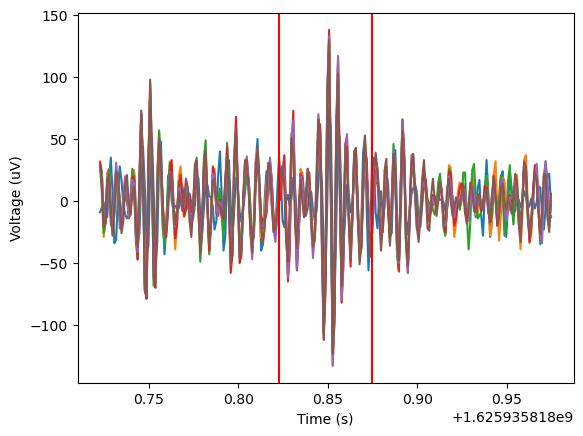

In [103]:
import matplotlib.pyplot as plt

ripple_band_df = (lfp_band.LFPBandV1() & lfp_band_key).fetch1_dataframe()

window = 0.1
i = -1
ripple_start = ripple_times.iloc[i].start_time
ripple_end = ripple_times.iloc[i].end_time
plt.plot(
    ripple_band_df.loc[ripple_start - window : ripple_end + window].index,
    ripple_band_df.loc[ripple_start - window : ripple_end + window].iloc[
        :, ::15
    ],
)
plt.axvline(ripple_start, color="r")
plt.axvline(ripple_end, color="r")

plt.xlabel("Time (s)")
plt.ylabel("Voltage (uV)")

## Up Next

We will learn how to [extract spike waveform features](./40_Extracting_Clusterless_Waveform_Features.ipynb) to decode neural data.
